In [1]:
# importing packages
%matplotlib inline
import numpy as np
import pandas as pd
import wrds
import PyBondLab as pbl


# Load the data
we use `'ISSUE_ID'` column as the bond identifier and `'RET_L5M'` column for bond returns in the fit() method.
Alternatively, you can rename columns as `"ID"` and `"ret"` and just call the .fit() method later

In [2]:
# =============================================================================
# Option 1: access data directly from WRDS
# =============================================================================
# Assumes you have a valid WRDS account and have set-up your cloud access #
# See:
# https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-wrds-cloud/
wrds_username = '' # Input your WRDS username
db = wrds.Connection(wrds_username = wrds_username )

tbl1 = db.raw_sql("""SELECT  DATE, ISSUE_ID,CUSIP, RATING_NUM, RET_L5M,AMOUNT_OUTSTANDING,
                                TMT, N_SP, PRICE_L5M                         
                        FROM wrdsapps.bondret
                  """)
# Required because the WRDS data comes with "duplicates" in the index
# does not affect data, but the "index" needs to be re-defined #                 
tbl1 = tbl1.reset_index()
tbl1['index'] = range(1,(len(tbl1)+1))

# =============================================================================
# Option 2: Load any bond dataset you have saved to file
# =============================================================================
# file = '' # Input your file name, assumed to be saved as .csv #
# tbl1         =  pd.read_csv(file)

tbl1['index'] = range(1,(len(tbl1)+1))
# =============================================================================

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
# Format the data
tbl1.columns = tbl1.columns.str.upper()
tbl1['date'] = pd.to_datetime(tbl1['DATE'])
tbl1['AMOUNT_OUTSTANDING'] = np.abs(tbl1['AMOUNT_OUTSTANDING'])
tbl1['PRICE_L5M'] = np.abs(tbl1['PRICE_L5M'])
tbl1 = tbl1.sort_values(['ISSUE_ID','DATE'])

# WRDS data "starts" officially on "2002-08-31"
tbl1 = tbl1[tbl1['date'] >= "2002-08-31"]

# Column used for value weigted returns
tbl1['VW'] = (tbl1['PRICE_L5M'] * tbl1['AMOUNT_OUTSTANDING'])/1000


Initialize the strategy. We want to sort bonds according to their rating in 5 portfolios. The strategy has a holding period of 1 month.
The sorting is done with respect to the `RATING_NUM` column.

In [4]:
holding_period = 1             # holding period returns
n_portf        = 5             # number of portfolios
sort_var1      = 'RATING_NUM'  # sorting chararcteristic/variable
# initialize the strategy
single_sort = pbl.SingleSort(holding_period, sort_var1, n_portf)

-----------------------------------
Initializing strategy (single sort):
Holding period: 1 
Number of portfolios: 5 
Sorting on: RATING_NUM
-----------------------------------


Next, we create a dictionary to input parameters.
In the `"strategy"` key we input the strategy initialized before
In the `"rating"` key we specify if we want to filter out bonds. Possible inputs are `None`,`"IG"`,`"NIG"` to include all bonds, investment grade bonds, or non investment-grade bonds respectively.

if we want to apply filtering rules (see README):
In the `"filters"` key we specify a dictionary. In this example, we exclude bonds whose returns are greater than 20%.

Then use the StrategyConstruction with the data and the parameters to build the strategy

In [5]:
# parameters
params = {'strategy': single_sort,
          'rating':None,
          'filters':{"adj":"trim","level":0.2},
}

data = tbl1.copy()
# Fit the strategy to the data. Specify ID identifier and column of returns 
RESULTS = pbl.StrategyFormation(data, **params).fit(IDvar = "ISSUE_ID",RETvar = "RET_L5M")

plot() can be used to visualize the cumulative performance of the strategies.
If some filtering is applied, you can quickly compare the performance with ex ante and ex post exclusions

<Axes: title={'center': 'Equally-weighted cumulative performance'}, xlabel='Date', ylabel='Value ($)'>

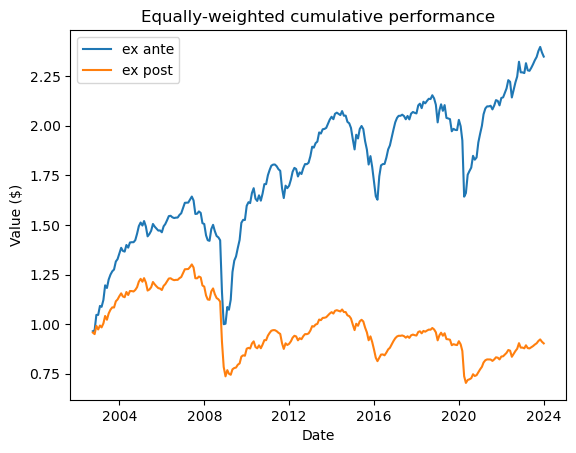

In [6]:
RESULTS.plot()

to retrive the long short portfolio returns use the get_long_short() method
get_long_leg() and get_short_leg() methods are used to retrieve the long and short leg of the portfolio respectively.
[get_long_leg_ex_post() and get_short_leg_ex_post() for the ex post counterpart]

In [7]:
ew,vw = RESULTS.get_long_short()
# ew_expost, vw_expost = RESULTS.get_long_short_expost()
ew 

,EWEA_ALL_1_trim_0.2
2002-08-31,NaN
2002-09-30,-0.035760
2002-10-31,0.005161
2002-11-30,0.079828
2002-12-31,-0.000041
...,...
2023-08-31,0.006984
2023-09-30,0.012773
2023-10-31,0.008708
2023-11-30,-0.011556


you can see some summary statistics of the bonds that are filtered out

In [8]:
RESULTS.stats_bonds_adj()

/Users/u1972481/Documents/test/PyBondLab/PyBondLab/PyBondLab.py:709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_cat'] = np.where(df['RATING_NUM']>10, 'NIG','IG')


,# Bonds,Avg. AMT. OUT,Avg. TMT,Avg. Ret,Std. Dev.,Min,25$^{th}$,Median,75$^{th}$,Max
IG,1731 (36.28%),"393,970",10.336,33.91%,18.44%,20.01%,22.76%,27.25%,36.30%,100.00%
NIG,3040 (63.72%),"432,895",7.282,38.67%,20.95%,20.00%,23.97%,30.55%,45.20%,100.00%
ALL,4771 (100.00%),"418,773",8.390,36.94%,20.20%,20.00%,23.53%,29.00%,41.89%,100.00%
